# Modeling
In this notebook, we are going to use the K-Means algorithm to segment the customers into different clusters. 

We will:
- Prepare the dataset for analysis by one hot encoding or label encoding the categorical data
- Choose the number of clusters by looking at the inertia and silhouette score
- Visualize the data from each cluster

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df = pd.read_pickle('./saved-items/df.pkl')

df.head()

,Age,Education,Relationship_Status,Income,Seniority,Num_children,Has_child,Wines,Fruits,Meat,Fish,Sweets,Gold,Total
0,64,Postgraduate,Alone,58138,9.30,0,False,635,88,546,172,88,88,1617
1,67,Postgraduate,Alone,46344,7.80,2,True,11,1,6,2,1,6,27
2,56,Postgraduate,Relationship,71613,8.34,0,False,426,49,127,111,21,42,776
3,37,Postgraduate,Relationship,26646,7.87,1,True,11,4,20,10,3,5,53
4,40,Postgraduate,Relationship,58293,7.93,1,True,173,43,118,46,27,15,422


In [3]:
df.dtypes

Age                      int64
Education               object
Relationship_Status     object
Income                   int32
Seniority              float64
Num_children             int64
Has_child                 bool
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
Total                    int64
dtype: object

## Convert Categorical Data to Numerical

In [4]:
# One Hot Encode Education column
df['Edu'] = df['Education'].apply(lambda x: 1 if x == "Postgraduate" else 0)
df['Child'] = df['Has_child'].apply(lambda x: 0 if x == False else 1)

# Label Encode the Relationship Status column
df['Single'] = df['Relationship_Status'].apply(lambda x: 1 if x == 'Alone' else 0)
df['Relationship'] = df['Relationship_Status'].apply(lambda x: 1 if x == 'Relationship' else 0)

In [5]:
df.head()

,Age,Education,Relationship_Status,Income,Seniority,Num_children,Has_child,Wines,Fruits,Meat,Fish,Sweets,Gold,Total,Edu,Child,Single,Relationship
0,64,Postgraduate,Alone,58138,9.30,0,False,635,88,546,172,88,88,1617,1,0,1,0
1,67,Postgraduate,Alone,46344,7.80,2,True,11,1,6,2,1,6,27,1,1,1,0
2,56,Postgraduate,Relationship,71613,8.34,0,False,426,49,127,111,21,42,776,1,0,0,1
3,37,Postgraduate,Relationship,26646,7.87,1,True,11,4,20,10,3,5,53,1,1,0,1
4,40,Postgraduate,Relationship,58293,7.93,1,True,173,43,118,46,27,15,422,1,1,0,1


Save new DataFrame with numerical columns

In [6]:
num_df = df[['Age', 'Edu', 'Single', 'Relationship', 'Income', 
             'Seniority', 'Num_children', 'Child', 'Wines', 
             'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Total']]

In [7]:
num_df.head()

,Age,Edu,Single,Relationship,Income,Seniority,Num_children,Child,Wines,Fruits,Meat,Fish,Sweets,Gold,Total
0,64,1,1,0,58138,9.30,0,0,635,88,546,172,88,88,1617
1,67,1,1,0,46344,7.80,2,1,11,1,6,2,1,6,27
2,56,1,0,1,71613,8.34,0,0,426,49,127,111,21,42,776
3,37,1,0,1,26646,7.87,1,1,11,4,20,10,3,5,53
4,40,1,0,1,58293,7.93,1,1,173,43,118,46,27,15,422


In [8]:
# Reset index
num_df.reset_index(drop=True, inplace=True)

In [9]:
num_df.dtypes

Age               int64
Edu               int64
Single            int64
Relationship      int64
Income            int32
Seniority       float64
Num_children      int64
Child             int64
Wines             int64
Fruits            int64
Meat              int64
Fish              int64
Sweets            int64
Gold              int64
Total             int64
dtype: object

In [10]:
correlation_df = num_df.corr()

correlation_df

,Age,Edu,Single,Relationship,Income,Seniority,Num_children,Child,Wines,Fruits,Meat,Fish,Sweets,Gold,Total
Age,1.000000,0.150562,-0.002742,0.002742,0.213892,-0.011716,0.092613,-0.012594,0.165217,0.014301,0.040568,0.042514,0.021999,0.062217,0.119028
Edu,0.150562,1.000000,0.021456,-0.021456,0.170706,-0.039177,0.048169,0.026338,0.154653,0.006447,0.091924,-0.026936,-0.026147,0.013409,0.117393
Single,-0.002742,0.021456,1.000000,-1.000000,0.011392,0.011301,-0.041488,-0.057790,0.007194,0.025961,0.031876,0.015231,0.016612,0.022591,0.021740
Relationship,0.002742,-0.021456,-1.000000,1.000000,-0.011392,-0.011301,0.041488,0.057790,-0.007194,-0.025961,-0.031876,-0.015231,-0.016612,-0.022591,-0.021740
Income,0.213892,0.170706,0.011392,-0.011392,1.000000,-0.025011,-0.349588,-0.409769,0.730689,0.537307,0.702905,0.551586,0.555735,0.416743,0.823645
Seniority,-0.011716,-0.039177,0.011301,-0.011301,-0.025011,1.000000,-0.025831,0.001345,0.168007,0.068329,0.090654,0.082570,0.080921,0.161501,0.158455
Num_children,0.092613,0.048169,-0.041488,0.041488,-0.349588,-0.025831,1.000000,0.799059,-0.356040,-0.396008,-0.513539,-0.428121,-0.391436,-0.267747,-0.500347
Child,-0.012594,0.026338,-0.057790,0.057790,-0.409769,0.001345,0.799059,1.000000,-0.345349,-0.411579,-0.586141,-0.449993,-0.404827,-0.244919,-0.522597
Wines,0.165217,0.154653,0.007194,-0.007194,0.730689,0.168007,-0.356040,-0.345349,1.000000,0.385133,0.593755,0.397339,0.388580,0.391378,0.897616
Fruits,0.014301,0.006447,0.025961,-0.025961,0.537307,0.068329,-0.396008,-0.411579,0.385133,1.000000,0.568336,0.591464,0.571195,0.390442,0.614031


We want to group customers by how much they spend, so we will choose columns with high correlation values with `Total` column

In [11]:
# Strong positive correlation with 'Total'
pos_corr = correlation_df['Total'][(correlation_df['Total'] >= 0.5)]
pos_corr

Income    0.823645
Wines     0.897616
Fruits    0.614031
Meat      0.857106
Fish      0.644740
Sweets    0.609521
Gold      0.529779
Total     1.000000
Name: Total, dtype: float64

In [12]:
# Strong negative correlation with 'Total'
neg_corr = correlation_df['Total'][(correlation_df['Total'] <= -0.5)]
neg_corr

Num_children   -0.500347
Child          -0.522597
Name: Total, dtype: float64

All items

# NOTE
This is where I remove the `Child` column because it was heavily impacting my model during my initial attempt. `Num_children` is enough.

In [13]:
all_df = num_df[neg_corr.index.tolist() + pos_corr.index.tolist()].copy()

X = all_df.drop('Child', axis=1).copy()

X.head()

,Num_children,Income,Wines,Fruits,Meat,Fish,Sweets,Gold,Total
0,0,58138,635,88,546,172,88,88,1617
1,2,46344,11,1,6,2,1,6,27
2,0,71613,426,49,127,111,21,42,776
3,1,26646,11,4,20,10,3,5,53
4,1,58293,173,43,118,46,27,15,422


Remove the singular items

In [14]:
# X = num_df[['Num_children', 'Child', 'Income', 'Total']]

# X.head()

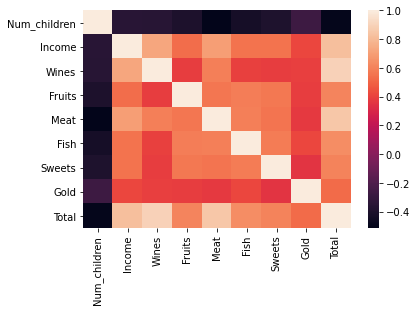

In [15]:
sns.heatmap(X.corr())
plt.show()

## Scale the data between 0 and 1

In [16]:
scaler = MinMaxScaler()

In [17]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

,Num_children,Income,Wines,Fruits,Meat,Fish,Sweets,Gold,Total
0,0.000000,0.503625,0.425318,0.442211,0.316522,0.664093,0.335878,0.274143,0.639683
1,0.666667,0.398325,0.007368,0.005025,0.003478,0.007722,0.003817,0.018692,0.008730
2,0.000000,0.623933,0.285332,0.246231,0.073623,0.428571,0.080153,0.130841,0.305952
3,0.333333,0.222456,0.007368,0.020101,0.011594,0.038610,0.011450,0.015576,0.019048
4,0.333333,0.505009,0.115874,0.216080,0.068406,0.177606,0.103053,0.046729,0.165476


# K Means Clustering

We will use inertia and silhouette scores to determine what the best number of clusters is

In [18]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
scores   = {}
inertias = {}

for i in clusters:
    kmeans = KMeans(n_clusters=i, n_init=50)  # , algorithm='full')
    kmeans.fit(X_scaled)
    scores[i] = silhouette_score(X_scaled, kmeans.labels_)
    inertias[i] = kmeans.inertia_

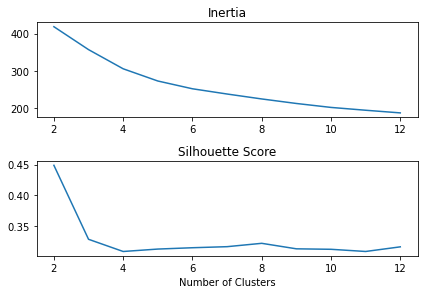

In [19]:
# Two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2)

# Inertia
ax1.plot(list(inertias.keys()), list(inertias.values()))
ax1.set_title('Inertia')

# Silhouette Score
ax2.plot(list(scores.keys()), list(scores.values()))
ax2.set_title('Silhouette Score')

# Spacing
fig.tight_layout()

# X-Axis Label
plt.xlabel('Number of Clusters')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.47236915421742814


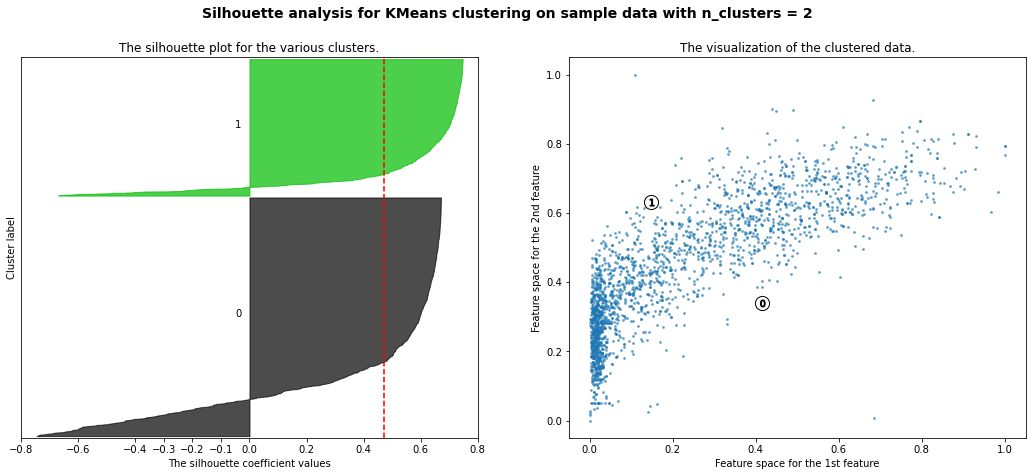

For n_clusters = 3 The average silhouette_score is : 0.28710318132496837


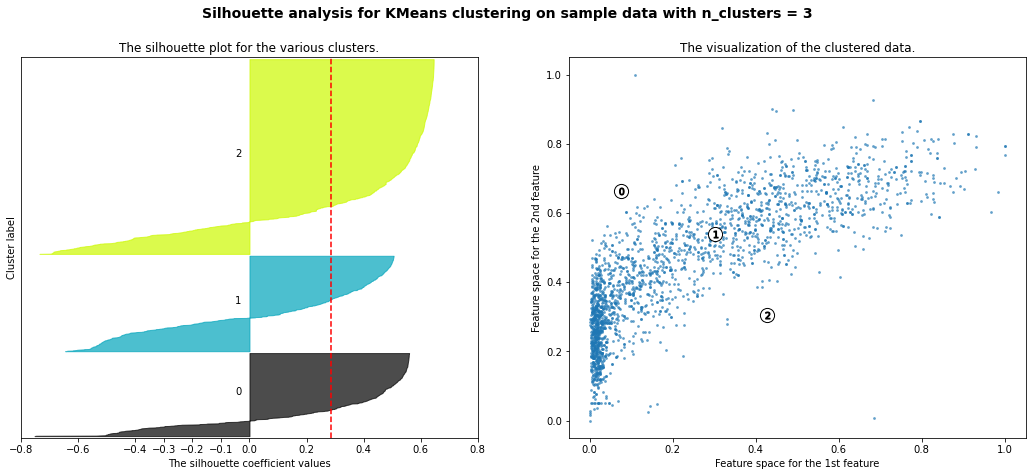

For n_clusters = 4 The average silhouette_score is : 0.0279335043179804


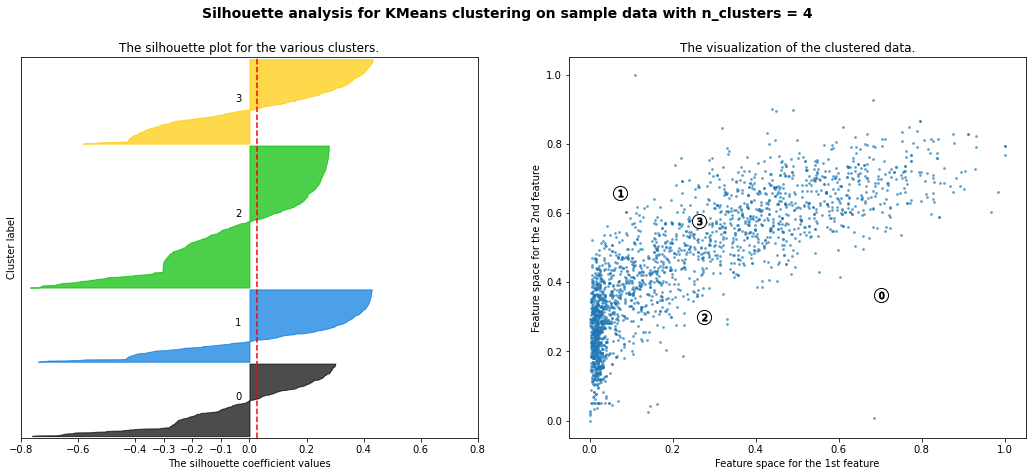

For n_clusters = 5 The average silhouette_score is : -0.004055030855075496


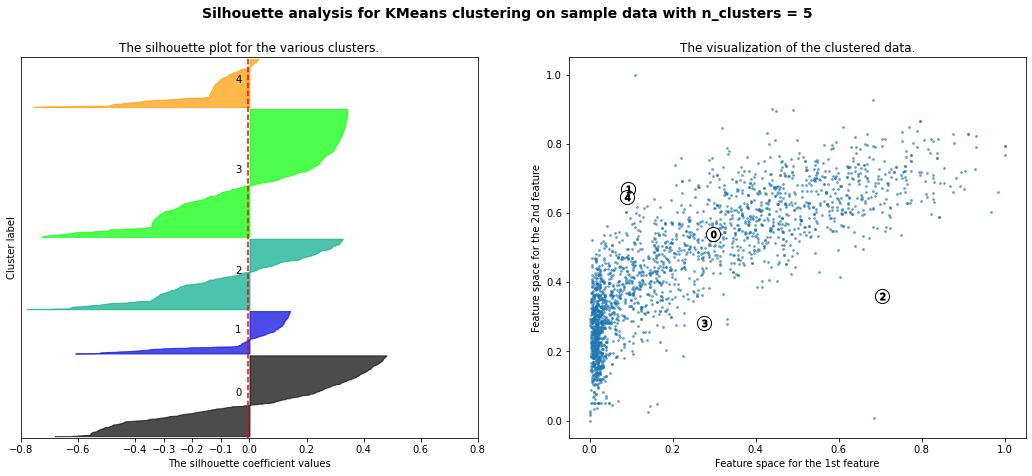

For n_clusters = 6 The average silhouette_score is : -0.02574338462673571


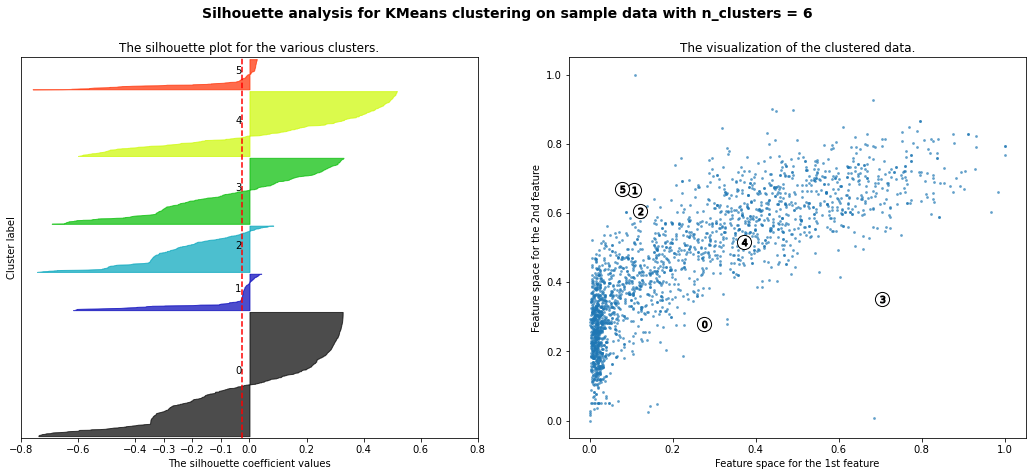

For n_clusters = 7 The average silhouette_score is : -0.04366348942732093


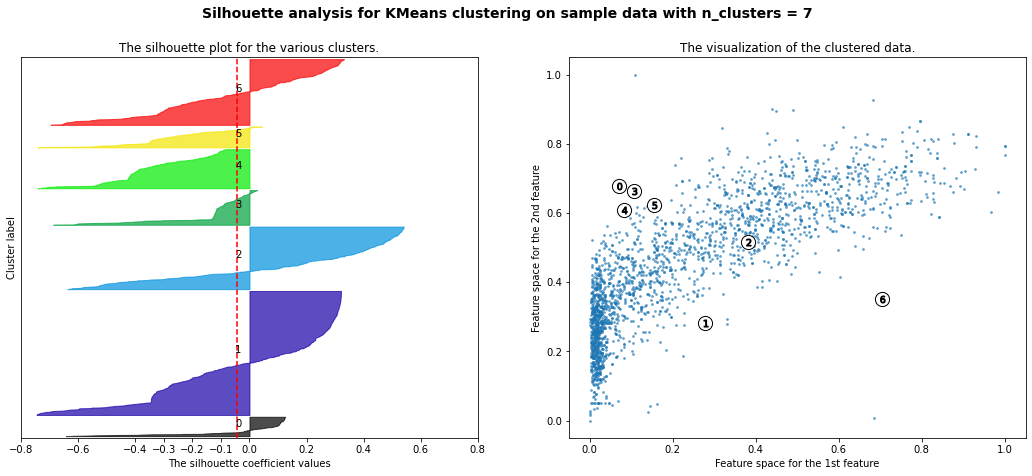

For n_clusters = 8 The average silhouette_score is : -0.050920557844774415


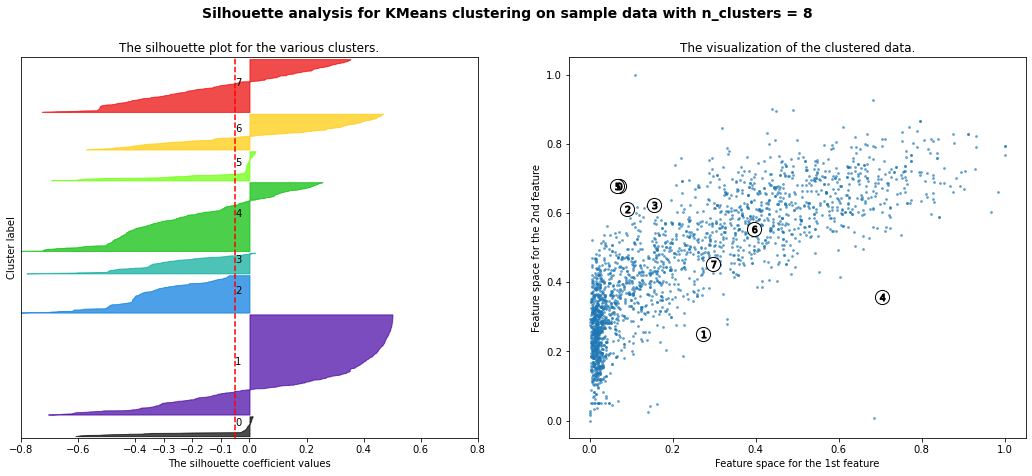

For n_clusters = 9 The average silhouette_score is : -0.11854904246440946


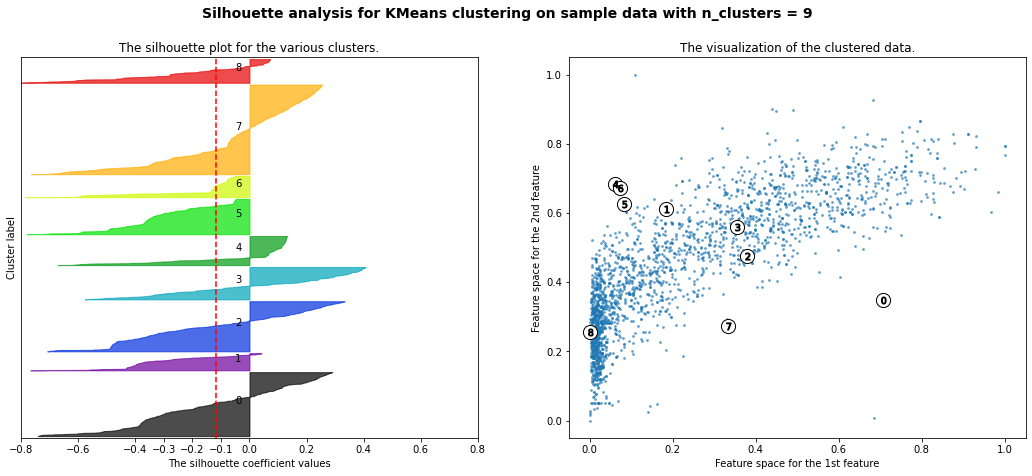

For n_clusters = 10 The average silhouette_score is : -0.12766472606061743


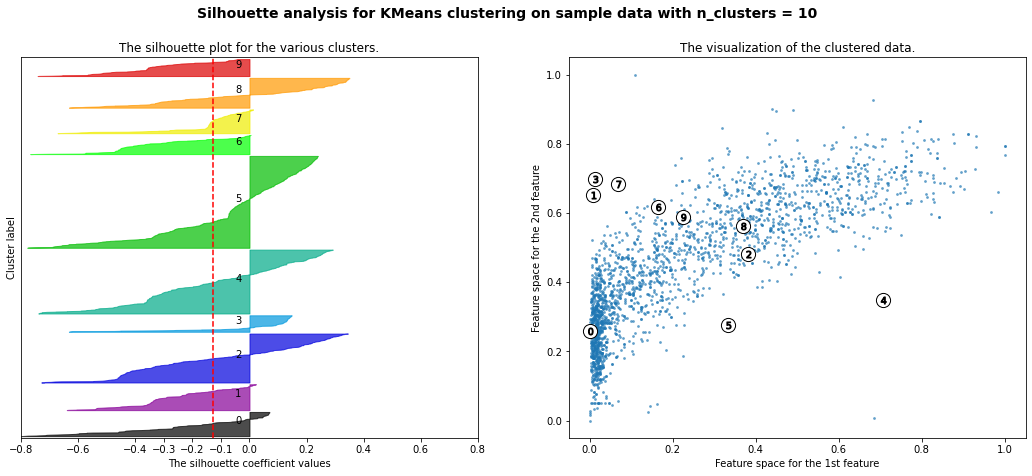

In [20]:
cluster_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in cluster_range:
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.8, 0.8])
    
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Cluster
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.8, -0.6, -0.4, -0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled['Total'], X_scaled['Income'], marker=".", s=30, lw=0, alpha=0.7, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    plt.show()

3 clusters appears to be the best, according to the inertia and silhouette score

In [21]:
kmeans = KMeans(n_clusters=3, n_init=100, algorithm='full', random_state=10)
kmeans.fit(X_scaled)

KMeans(algorithm='full', n_clusters=3, n_init=100, random_state=10)

Add the labels to the datasets

In [22]:
X_scaled['labels'] = kmeans.labels_
X['labels'] = kmeans.labels_

In [23]:
X.head()

,Num_children,Income,Wines,Fruits,Meat,Fish,Sweets,Gold,Total,labels
0,0,58138,635,88,546,172,88,88,1617,2
1,2,46344,11,1,6,2,1,6,27,0
2,0,71613,426,49,127,111,21,42,776,1
3,1,26646,11,4,20,10,3,5,53,0
4,1,58293,173,43,118,46,27,15,422,1


In [24]:
X_scaled.head()

,Num_children,Income,Wines,Fruits,Meat,Fish,Sweets,Gold,Total,labels
0,0.000000,0.503625,0.425318,0.442211,0.316522,0.664093,0.335878,0.274143,0.639683,2
1,0.666667,0.398325,0.007368,0.005025,0.003478,0.007722,0.003817,0.018692,0.008730,0
2,0.000000,0.623933,0.285332,0.246231,0.073623,0.428571,0.080153,0.130841,0.305952,1
3,0.333333,0.222456,0.007368,0.020101,0.011594,0.038610,0.011450,0.015576,0.019048,0
4,0.333333,0.505009,0.115874,0.216080,0.068406,0.177606,0.103053,0.046729,0.165476,1


In [25]:
X_scaled.corr()['labels'].sort_values(ascending=False)

labels          1.000000
Total           0.907922
Income          0.809050
Meat            0.789440
Wines           0.750172
Fish            0.724939
Fruits          0.685376
Sweets          0.671219
Gold            0.517368
Num_children   -0.544031
Name: labels, dtype: float64

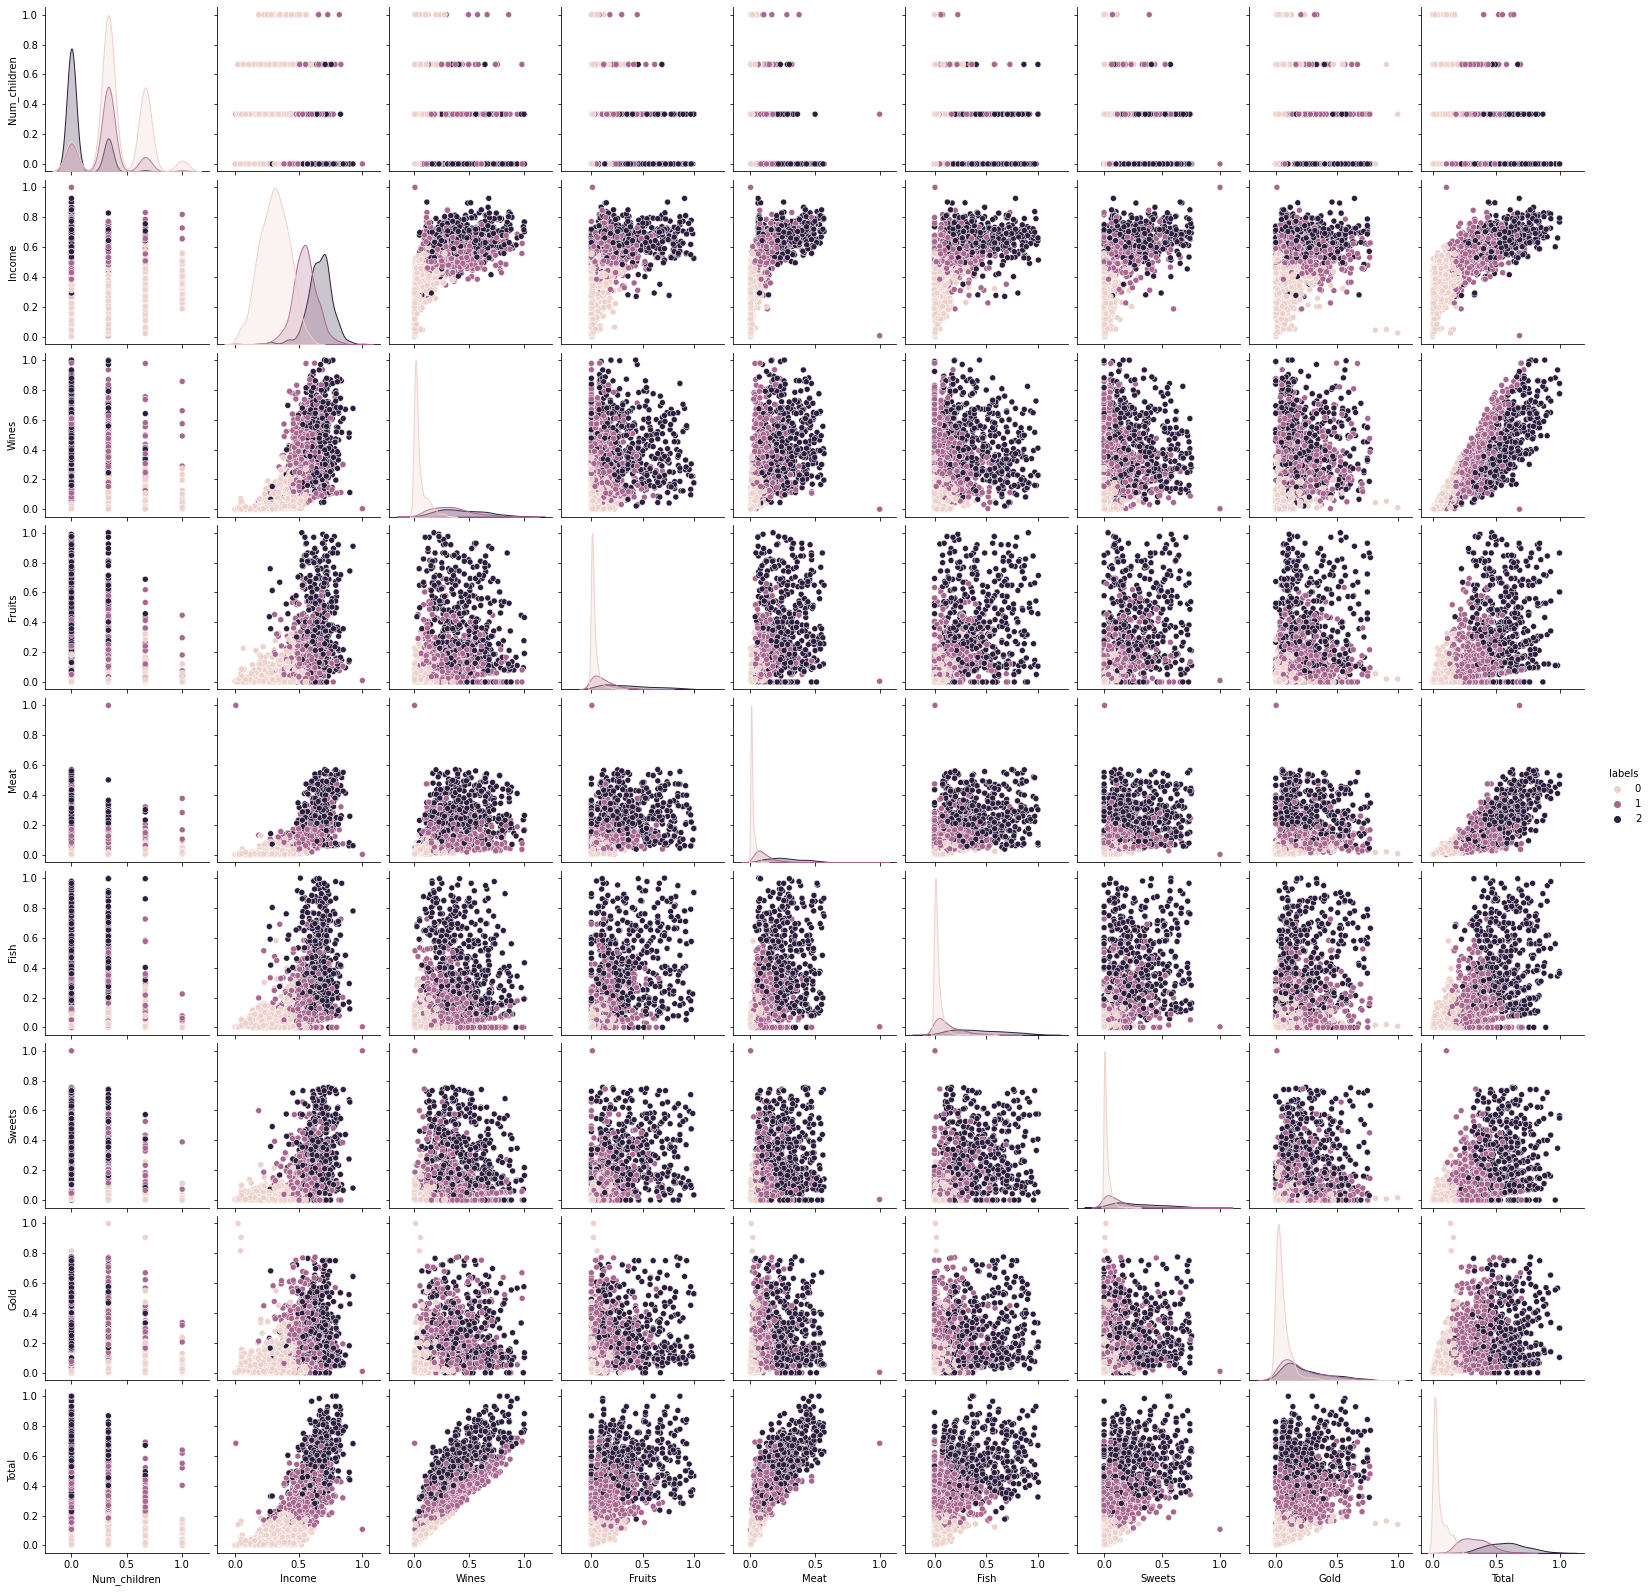

In [26]:
sns.pairplot(X_scaled, hue='labels')
plt.show()

# Let's take a closer look at the `Total` column

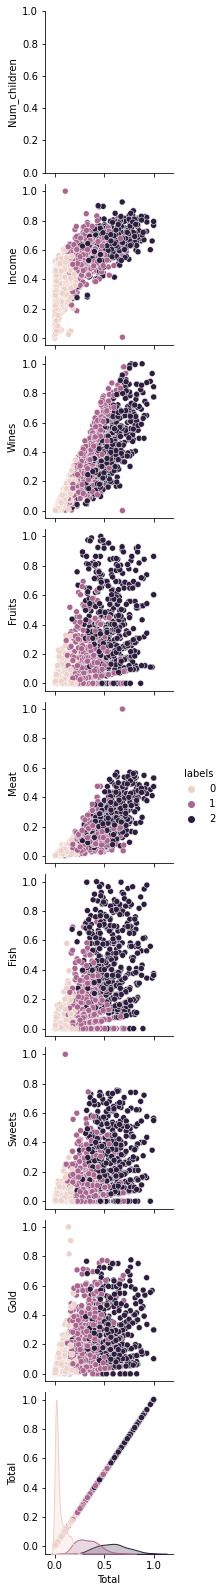

In [27]:
sns.pairplot(X_scaled, hue='labels', x_vars=['Total'])
plt.show()

# Save labeled dataset as pickle object and as a csv file

In [28]:
# pickle
X.to_pickle("./saved-items/labeled.pkl")

# csv file
X.to_csv("./saved-items/clustered-dataset.csv", index=False)